In [69]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input
from tensorflow.keras.utils import plot_model
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [70]:
def build_Encoder(image_shape, latent_dim):
  def sampling(mu_log_var):
    mu, log_var = mu_log_var
    sample=mu+tf.keras.backend.exp(0.5*log_var*tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0,
    stddev=1.0))
    return sample
  # image_shape=(28,28,1)
  input=keras.Input(image_shape)
  # model.add(keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255, input_shape=(28, 28)))
  x=keras.layers.Conv2D(1, (3,3), strides=1, padding='same')(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2D(32, (3,3), strides=1, padding='same')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2D(64, (3,3), strides=2, padding='same')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  outputs=tf.keras.layers.Flatten()(x)
  # latent_dim=2
  mu=keras.layers.Dense(latent_dim)(outputs)
  log_var=keras.layers.Dense(latent_dim)(outputs)
  outputs_model=[mu,log_var]
  z=tf.keras.layers.Lambda(sampling, mask=None, arguments=None)([mu,log_var])
  model = keras.Model(inputs=input, outputs=z, name="build_Encoder")
  
   
  return model

Model: "build_Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 28, 28, 1)    10          ['input_34[0][0]']               
                                                                                                  
 batch_normalization_104 (Batch  (None, 28, 28, 1)   4           ['conv2d_78[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_117 (LeakyReLU)    (None, 28, 28, 1)    0           ['batch_normalization

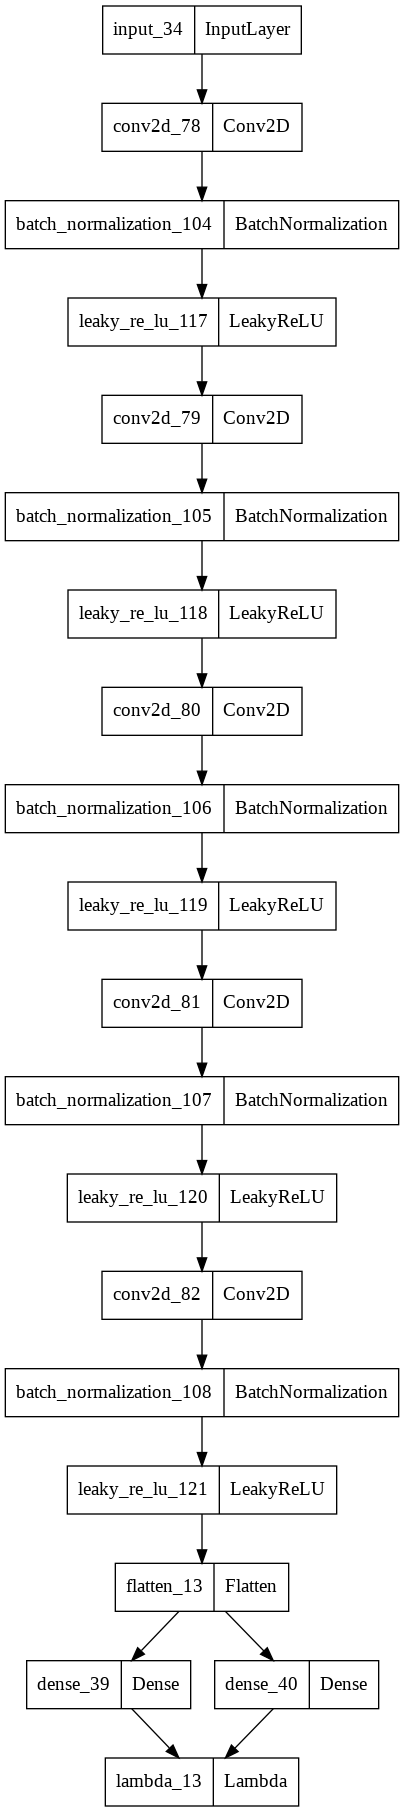

In [71]:
# image_shape=(28,28,1)
# latent_dim=2
model=build_Encoder((28,28,1),2) 
model.summary()
plot_model(model,to_file='Encoder_graph.png')

In [72]:
def build_Decoder(latent_dim):
  input=keras.Input(latent_dim)
  x=keras.layers.Dense(3136)(input)
  x=keras.layers.Reshape((7, 7, 64))(x)
  x=keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding="same")(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2, 2), padding="same")(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2, 2), padding="same")(x)
  x=keras.layers.BatchNormalization()(x)
  x=keras.layers.LeakyReLU(alpha=0.2)(x)
  x=keras.layers.Conv2DTranspose(filters=28, kernel_size=(3,3), strides=(1, 1), padding="same")(x)
  output=keras.layers.LeakyReLU(alpha=0.2)(x)
  model = keras.Model(inputs=input, outputs=output, name="build_Decoder")

  return model

Model: "build_Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_41 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_83 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_109 (Ba  (None, 7, 7, 64)         256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_122 (LeakyReLU)  (None, 7, 7, 64)         0         
                                                     

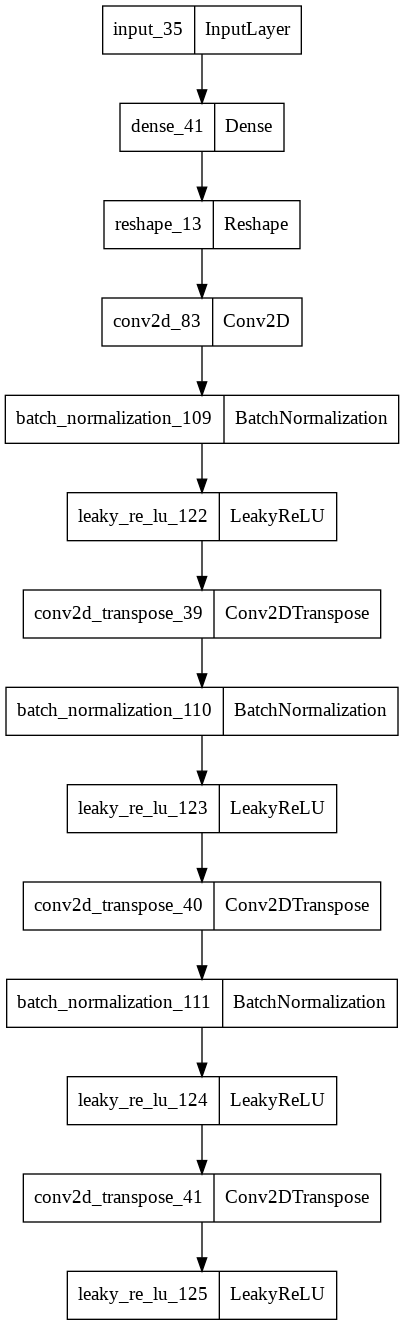

In [73]:
model=build_Decoder(2) 
model.summary()
plot_model(model,to_file='Decoder_graph.png')

In [74]:
vae_input = tf.keras.layers.Input(shape=(28,28,1), name="VAE_input")

In [75]:
vae_encoder_output = encoder(vae_input)

In [57]:
vae_decoder_output = decoder(vae_encoder_output)

In [83]:
vae =keras.Model(inputs=vae_input, outputs=vae_decoder_output, name="VAE")

ValueError: ignored

In [41]:
# def vae(encoder, decoder):
#   input=keras.Input(encoder)
#   vae=input.add(decoder)
#   return vae

In [ ]:
# encoder=build_Encoder((28,28,1),2)
# decoder=build_Decoder(2)
# vae_model=vae(encoder, decoder)

In [59]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [62]:
mu=2
log_var=2
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss=loss_func(mu,log_var))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
# Training the VAE
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

In [65]:
x_train = x_train.astype("float32") / 255.0 
x_test = x_test.astype("float32") / 255.0

In [66]:
x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)) 
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [68]:
vae.fit(x_train, x_train, epochs=20, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20


NameError: ignored

In [ ]:
encoder.save("VAE_encoder.h5") 
decoder.save("VAE_decoder.h5") 
vae.save("VAE.h5")